# Break Down of running a network on CIFAR10
Hi all, this is a notebook to help break down running a network on CIFAR10. It will be similar to the tutorial on the PyTorch website; however, I'll go over some pointers for making some deep learning code more modular, specfic issues you may run into with your assignment, and a few extra things for those who are intrested.

## Imports
torch - PyTorch module 

torchvision - PyTorch Vision library

torch.optim - PyTorch optimizer module, you implimented SGD


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

## Importing the CIFAR10 dataset
PyTorch vision makes it really easy to import some of the well known datasets here's more information on some of them: https://pytorch.org/docs/stable/torchvision/datasets.html 

In [28]:
# data transformation to normalize data
# normalizing data helps your optimization algorithm converge more quickly
transform = transforms.Compose(
    [transforms.ToTensor(),     # Transforms to Tensor, which is just a matrix 0 to 1 I think
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # The first 3-tuple is means; the second is Standard Deviations


# training set split
trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=True, 
                                        transform=transform) # Applies the above defined ToTensor & Normalize transformations

# testing set split, this portion is similar to your assignment
# but instead of passing in trainset you need to pass in an instance 
# of a custom data object which is provided in the starter code

trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=4,
                                          shuffle=True, 
                                          num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False, # This specifies that we want the Test set, not the train set.
                                       download=True, 
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=10,
                                         shuffle=False, 
                                         num_workers=2)

# labeling the classes of images just like the digits of MNIST, or the 
# the breeds of dogs from DogNet

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [22]:
trainloader

In [24]:
len(trainloader) # Number of minibatches # Note that trainloader was defined with batch_size=4, therefore there are 60,000 images total

12500

## Using the GPU

One of the most best ways to speed up the training process of a deep network is to use a GPU (or TPU if you can). This is because with a GPU we can train a whole batch of data in parallel. This section is optinal and i'll mark the other parts of the code where this comes up. But, for those of you intrested and able to utilze a GPU I highly reccomend it! To do so just install CUDA and update your GPU drivers. 

In [33]:
device = torch.device('cuda' if torch.cuda.is_available()  else 'cpu')
print('Using device: ', device)

Using device:  cpu


## Plotting the images

This function just plots some of the imagges from the training set, I would pay attention to this section because it can help make plotting the images from dogset and synth data a lot easier. 

In [15]:
trainset.__getitem__(0)[0].shape

torch.Size([3, 32, 32])

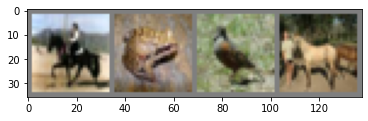

horse  frog  bird horse


In [25]:
def imshow(img):
    img = img/2  +0.5  # have to unnormalize the images
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader) # The iter command creates an iterator; it can do that because trainloader has the __getitem__() parameter
images, labels = dataiter.next() # We get 4 images, because we specified the batch_size of trainloader to be 4

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Building your network
Below we build a simple network and the forward pass of the network. On the PyTorch website they use some notation which is slightly dated.

`import torch.nn.functional as F
F.relu(...)`

Most activation functions are just in the torch.nn module now. 


In [29]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5) # Flattens
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x


net = Net()

In [19]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Training and Testing Functions
Here I've just made the training and testing portions of the orignal tutorial into functions. I added some more comments to further break down what's going on.

In [35]:
def train_model(model, criterion, optimizer, trainloader, epochs=10, devloader=None, print_info=True):
    epochs_loss = []
    epoch_acc = []
    running_loss = 0.0
    # the length of the train loader will give you the number of mini-batches
    # not the cleanest solution but for now it generalizes well and avoids 
    # computation that we don't need
    minibatches = len(trainloader)
    # moving the network onto the gpu/cpu
    model = model.to(device)
    for epoch in range(epochs):
        epoch_loss = 0.0
        batches_complete = 0
        for batch, labels in trainloader: # Per this doc, (batch,labels) = trainloader.__getitem__(); https://pytorch.org/docs/stable/torchvision/datasets.html#cifar

            # Keeping track of number of batches processed
            if batches_complete % 1000 == 0:
                print("BATCHES COMPLETE: ", batches_complete)
            batches_complete += 1
            
            # batch is a tensor with m elements, where each element is 
            # a training example

            # moving batch/labels onto the gpu/cpu
            batch, labels = batch.to(device), labels.to(device)
            
            # zeroing the parameters of the model 
            # becuase we want to optimize them
            optimizer.zero_grad()
            
            # forward pass
            # getting the predictions from our model by passing in a mini-batch
            # the ouput will have shape (mini-batch-size, number-of-classes)
            # where each element of output is the probabliity of that example being
            # the classification correspoding to the index of the value
            output = model(batch)
            loss = criterion(output, labels)
            
            # backward pass
            loss.backward()
            
            # optimize the parameters
            optimizer.step()
            
            # add the loss of a mini-batch to the list of epoch loss
            epoch_loss += loss.item()

        #  after each epoch we need to average out the loss across all minibatches
        epochs_loss.append(epoch_loss/minibatches)
        # printing some info
        if print_info:
            print(f'Epoch: {epoch} Loss: {epoch_loss/minibatches}')
    return model, epoch_loss
                

In [36]:
def test_model(model, testloader): # Takes in just model you want to test and the data you want to test it on
    # variables to keep count of correct labels and the total labels in a mini batch
    correct = 0
    total = 0
    # since we're testing the model we don't need to perform backprop
    with torch.no_grad(): # Disables gradient calculation to save memory; we're sure we won't be using Tensor.backward()
        for batch, labels in testloader:
            batch, labels = batch, labels # So we don't modify original dataset?
            output = model(batch)
            # this gives us the index with the highest value outputed from the last layer
            # which coressponds to the most probable label/classification for an image
            predicted = torch.max(output.data, 1)[1]
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

## Putting it together 
Here we make a model from the Net() and train it for 100 epochs, and then test it on our testing data we set aside earlier.

In [37]:
net = Net()
net, loss = train_model(net,
                        epochs=1,
                        criterion = nn.CrossEntropyLoss(),
                        optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999)),
                        trainloader=trainloader
                        )
net.to('cpu')
test_model(net, testloader)

BATCHES COMPLETE:  999
BATCHES COMPLETE:  1999
BATCHES COMPLETE:  2999
BATCHES COMPLETE:  3999
BATCHES COMPLETE:  4999
BATCHES COMPLETE:  5999
BATCHES COMPLETE:  6999
BATCHES COMPLETE:  7999
BATCHES COMPLETE:  8999
BATCHES COMPLETE:  9999
BATCHES COMPLETE:  10999
BATCHES COMPLETE:  11999
Epoch: 0 Loss: 2.3064920886039735
Accuracy of the network on the 10000 test images: 10 %


## Saving and loading a model
When working with a network it can take a long time to train. To save sometime if you have to come back to a project you can save the weights of a model using the cell below. The cell following just shows how you can load the saved model.

In [101]:
# saving a model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)


In [76]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

----------

# Some basic tests

In [10]:
x = torch.empty(5, 3) # Uninitialize --> Whatever is in memory will be in the matrix
print(x)

tensor([[0.0000e+00, 1.5846e+29, 0.0000e+00],
        [1.5846e+29, 2.2421e-44, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])


In [15]:
x = torch.rand(5, 3) # Initialized with random [0-1]
print(x)

tensor([[0.9080, 0.8758, 0.8815],
        [0.6555, 0.0099, 0.8844],
        [0.8251, 0.3148, 0.6692],
        [0.3101, 0.6219, 0.4257],
        [0.2716, 0.9391, 0.0575]])


In [16]:
x = torch.zeros(5, 3, dtype=torch.long) # Just zeros
print(x)

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])


In [17]:
x = torch.tensor([5.5, 3])
print(x)

tensor([5.5000, 3.0000])


In [18]:
x = x.new_ones(5, 3, dtype=torch.double)      # new_* methods take in sizes
print(x)

x = torch.randn_like(x, dtype=torch.float)    # override dtype!
print(x)                                      # result has the same size

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], dtype=torch.float64)
tensor([[-0.1533, -0.9017, -0.2420],
        [ 0.8956,  1.4480, -0.2635],
        [ 0.9218,  0.0399,  2.0148],
        [ 0.0409,  1.2370,  1.5403],
        [-1.5327,  3.4417, -2.2215]])


In [24]:
print(x.size())
print(x.size()[0])
print(x.size()[1])

torch.Size([5, 3])
5
3


### Two different syntax for addition

In [27]:
y = torch.rand(5, 3)
print(x + y)

tensor([[ 0.0071, -0.6817,  0.4185],
        [ 1.8353,  1.7157,  0.6514],
        [ 1.3860,  0.6804,  2.6430],
        [ 0.6545,  2.0417,  1.6803],
        [-0.9352,  3.9899, -1.7303]])


In [31]:
print(torch.add(x, y))

tensor([[ 0.0071, -0.6817,  0.4185],
        [ 1.8353,  1.7157,  0.6514],
        [ 1.3860,  0.6804,  2.6430],
        [ 0.6545,  2.0417,  1.6803],
        [-0.9352,  3.9899, -1.7303]])


### specify out=

In [ ]:
result = torch.empty(5, 3)
torch.add(x, y, out=result)
print(result)

### ! Any method with an _ at the end will mutate the tensor in place!

In [34]:
y.add_(x)
print(y)

tensor([[-0.2995, -2.4851, -0.0655],
        [ 3.6265,  4.6117,  0.1244],
        [ 3.2295,  0.7602,  6.6726],
        [ 0.7363,  4.5157,  4.7608],
        [-4.0006, 10.8733, -6.1733]])


In [39]:
x.t_() # Transpose! 

tensor([[-0.1533,  0.8956,  0.9218,  0.0409, -1.5327],
        [-0.9017,  1.4480,  0.0399,  1.2370,  3.4417],
        [-0.2420, -0.2635,  2.0148,  1.5403, -2.2215]])

### np.reshape = torch.view

In [40]:
x = torch.randn(4, 4)
y = x.view(16)
z = x.view(-1, 8)  # the size -1 is inferred from other dimensions
print(x.size(), y.size(), z.size())

torch.Size([4, 4]) torch.Size([16]) torch.Size([2, 8])


### If you have a one element tensor, use .item() to get the value as a Python number

In [42]:
x = torch.randn(1)
print(x)
print(x.item())
print(type(x.item()))

tensor([-1.2558])
-1.2558274269104004
<class 'float'>


### Converting to Numpy and Back

In [43]:
a = torch.ones(5)
b = a.numpy()
print(b)

[1. 1. 1. 1. 1.]


In [45]:
a.add_(1) # !!!! See how the numpy array changed in value !!!! i.e. b is just a pointer, not an actual copy of the data!
print(a)
print(b)

tensor([3., 3., 3., 3., 3.])
[3. 3. 3. 3. 3.]


In [47]:
a = np.ones(5)
b = torch.from_numpy(a)
np.add(a, 1, out=a) # !!!! See how the numpy array changed in value !!!! i.e. b is just a pointer, not an actual copy of the data!
print(a) 
print(b)

[2. 2. 2. 2. 2.]
tensor([2., 2., 2., 2., 2.], dtype=torch.float64)


# Autograd - Automatic Differentiation
The autograd package provides automatic differentiation for all operations on Tensors. It is a define-by-run framework, which means that your backprop is defined by how your code is run, and that every single iteration can be different.

In [68]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


In [69]:
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


In [70]:
print(x.grad_fn)
print(y.grad_fn)


None


In [71]:
z = y * y * 3
out = z.mean()

print(z, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)


In [76]:
print(out)

tensor(27., grad_fn=<MeanBackward0>)


In [72]:
print(out.grad)

None


<ipython-input-72-b5f72fce5729>:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  print(out.grad)


In [73]:
out.backward()

In [74]:
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


### Vector Jacobian product
Jacobian matrix is matrix of y_vector w.r.t. x_vector; it is an MxN matrix where M = |y| and N = |x|  
Use torch.autograd to compute vector-Jacobian product (i.e. this is the gradient multiplied by a vector, the stuff you use in backprop)  
More specifically, J.T.dot(v) (The transpose of the Jacobian dot product with a vector v, which is the gradient) ... I kind of get it

In [94]:
x = torch.randn(3, requires_grad=True)

y = x * 2
while y.data.norm() < 1000: # .norm() gives back the norm i.e. size of vector
    y = y * 2

print(y)

tensor([-1269.9690, -1067.1306,  -863.4456], grad_fn=<MulBackward0>)


In [95]:
v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float)
y.backward(v)

print(x.grad)

tensor([1.0240e+02, 1.0240e+03, 1.0240e-01])


# Building a simple model

In [130]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [131]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3) # The 6 output channels refers to the fact we have 6 different 3x3 convolution filters
        # Subsampling layer missing in here? I think subsampling is referring to Max pooling from a 2x2 filter
        self.conv2 = nn.Conv2d(6, 16, 3) # The 16 output channels here refer to the 16 filters
        # Subsampling layer missing in here? I think subsampling is referring to Max pooling from a 2x2 filter
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension # I think it has to be 5x5?
        self.fc2 = nn.Linear(120, 84) # 120 nodes fully connected to 84 nodes
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) # Aha, this is the max pooling, which is marked as "Subsampling" in the diagram
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) # Aha, this is the max pooling, which is marked as "Subsampling" in the diagram
        x = x.view(-1, self.num_flat_features(x)) # Flattens
        x = F.relu(self.fc1(x)) # ReLU activation
        x = F.relu(self.fc2(x)) # ReLU activation
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [132]:
params = list(net.parameters())
print(len(params))
print(params[0].size()) 

10
torch.Size([6, 1, 3, 3])


In [133]:
print(params[0]) # The weights for the first 6 filters/convolutions

Parameter containing:
tensor([[[[ 0.2230,  0.0625, -0.2623],
          [ 0.2541,  0.2451,  0.0715],
          [-0.0815,  0.3017, -0.1395]]],


        [[[-0.2171,  0.0228,  0.2983],
          [-0.1568,  0.1436,  0.0051],
          [-0.0042,  0.0360, -0.1720]]],


        [[[-0.1051,  0.1380, -0.0597],
          [ 0.0678, -0.1140, -0.1761],
          [-0.1786, -0.2951,  0.2860]]],


        [[[-0.0164, -0.0011, -0.1170],
          [-0.3077, -0.1589, -0.2617],
          [ 0.1522, -0.3259, -0.3131]]],


        [[[ 0.0593, -0.0181,  0.0893],
          [-0.2586, -0.1502, -0.2627],
          [-0.2471,  0.0397,  0.2232]]],


        [[[ 0.2773, -0.2956, -0.0196],
          [-0.2119,  0.2574,  0.1773],
          [ 0.0998,  0.1080,  0.1704]]]], requires_grad=True)


In [134]:
print(params[1]) # Not clear what this is; it corresponds to number of filters, but :shrug

Parameter containing:
tensor([-0.0357,  0.0527, -0.1153, -0.0450, -0.0939,  0.2645],
       requires_grad=True)


In [135]:
len(params[2]) # weights for 16 conv filters, each with 3x3

16

In [136]:
len(params[4]) # Input from flattened convolutions

120

### Putting in random input

In [137]:
# For example, nn.Conv2d will take in a 4D Tensor of nSamples x nChannels x Height x Width
input = torch.randn(1, 1, 32, 32) # 1 image, on 1 channel (i.e. grayscale i.e. just one 2D array with values)
out = net(input) # Interesting that we're not using .forward() :shrug
print(out)

tensor([[-0.0815,  0.0511,  0.2155,  0.0244,  0.1682, -0.0321,  0.0058,  0.0661,
          0.0844,  0.1288]], grad_fn=<AddmmBackward>)


In [138]:
net.zero_grad()
out.backward(torch.randn(1, 10))

### Loss Function

In [139]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.4617, grad_fn=<MseLossBackward>)


So, when we call loss.backward(), the whole graph is differentiated w.r.t. the loss, and all Tensors in the graph that has requires_grad=True will have their .grad Tensor accumulated with the gradient.

In [140]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

In [141]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([-0.0003,  0.0084, -0.0141,  0.0099, -0.0029,  0.0223])


### Updating Network Weights
The simplest update rule used in practice is the Stochastic Gradient Descent (SGD):

weight = weight - learning_rate * gradient


In [142]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

#### Using one of the built in optimizers

In [146]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

# Applying on CIFAR10